## Retrieving clinical lab results from HISE in R

v1.0 (2021-04-25)  
Lucas Graybuck  

### Purpose

In this notebook, we use the `hise` package in our IDE environment to locate and download clinical lab results.

This notebook was generated using the `R` language, running in the Jupyter Notebook environment on a HISE IDE instance. See the end of the document for the [Session Info](aSession-Info) for additional software version details.

<a name = "contents"></a>

### Contents

- [Loading hise](#Loading-hise)
- [Retrieving descriptors and lab results](#Retrieving-descriptors-and-lab-results)
- [Examining missing values](#Examining-missing-values)
- [Session Info](#Session-Info)

### Loading `hise`

Functions used to interact with the HISE SDK are stored in the `hise` package for R, which is installed by default on our IDE instances.

For this notebook, we'll also use the `purrr` package for some help with list traversal, and `visdat`, later in the notebook, to examine what we get back from HISE.

In [1]:
library(hise)
library(purrr)

In [2]:
if(!"visdat" %in% rownames(installed.packages())) {
    install.packages("visdat")
}
library(visdat)

We'll also use this helper function to convert file descriptors to a nicely structured data.frame:

In [3]:
fileDescToLabs <- function(descriptors) {
    assertthat::assert_that(class(descriptors) == "list")
    
    labs <- map(desc, "lab")
    with_labs <- ! map_lgl(labs, is.null)
    
    desc_df <- fileDescToDataframe(desc)
    desc_df <- desc_df[with_labs,]
    
    labs <- labs[with_labs]
    
    lab_types <- desc[[min(which(with_labs))]]$labDisplay$scheme
    common_labs <- intersect(names(lab_types),names(labs[[min(which(with_labs))]]))
    
    lab_types <- lab_types[common_labs]
    lab_names <- names(lab_types)
    lab_names <- tolower(lab_names)
    lab_names <- sub("%","percent", lab_names)
    lab_names <- gsub("[()]","",lab_names)
    lab_names <- gsub("-",".",lab_names)
    lab_names <- gsub(" ","_",lab_names)
    
    lab_types <- unlist(lapply(
        lab_types,
        function(lab) {
            if(lab$type %in% c("float","integer")) {
                "numeric"
            } else {
                "character"
            }
        }))
    
    labs_df <- purrr::map_dfr(
        labs,
        function(lab_res) {
            lab_res <- lab_res[common_labs]
            lab_res <- purrr::map2(
                lab_res, lab_types,
                function(res, lab_type) {
                    if(lab_type == "numeric") {
                        if(res %in% c('','999','999000')) {
                            suppressWarnings(as.numeric(NA))
                        } else {
                            suppressWarnings(as.numeric(res))
                        }
                    } else {
                        if(res == '') {
                            as.character(NA)
                        } else {
                            as.character(res)
                        }
                    }
                }
            )
            as.data.frame(lab_res)
        })
    
    names(labs_df) <- lab_names
    
    cbind(desc_df, labs_df)
}

### Retrieving descriptors and lab results

Currently, lab results are attached to file descriptors in HISE, so we need to specify a fileType to retrieve them.

One of the most common fileTypes for our samples is labeled scRNA-seq data, so we'll use "scRNA-seq-labeled" to pull lab results from all samples that have been through our RNA-seq pipeline.

In [4]:
desc <- getFileDescriptors(
    fileType = "scRNA-seq-labeled")

We'll then use our helper function, defined above, to retrieve the lab results:

In [5]:
lab_results <- fileDescToLabs(desc)

And save them to a file for later use:

In [6]:
write.csv(
    lab_results,
    "lab_results.csv"
)

### Examining missing values

Not all samples have clinical lab results attached to them, and some cohorts have specialized clinical labs performed that are related to the disease of interest. In addition, we may simply not have completed data ingest and storage for some cohorts or donors.

Thus, there are missing values in our clinical lab data in HISE, which we can investigate with the `visdat` package. 

This gives us a visual overview of what's available or missing in our lab_results table:

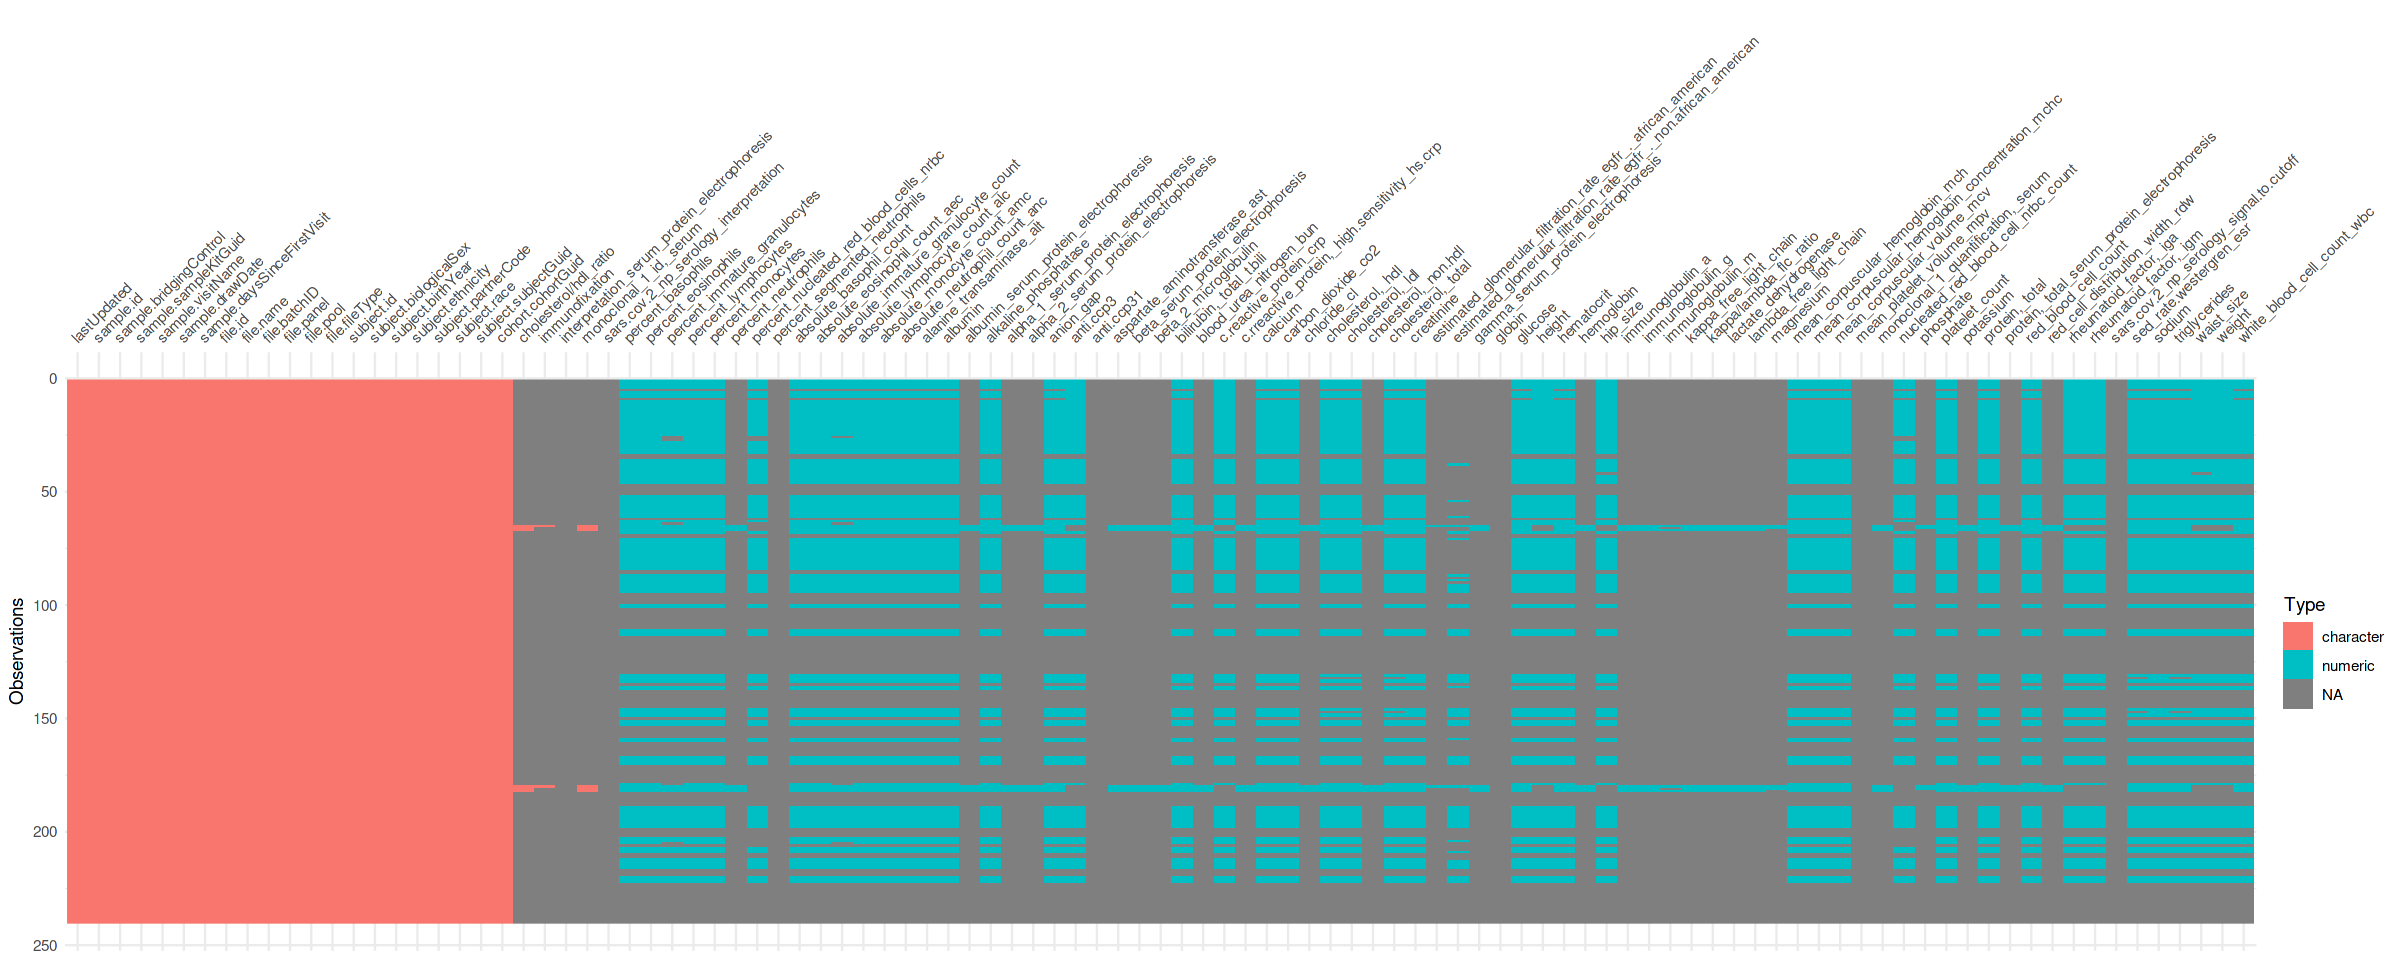

In [7]:
options(repr.plot.width = 20, repr.plot.height = 8)
vis_dat(lab_results)

We can also break this out by cohort, so we can see what's available for cohort-specific analyses:

In [8]:
table(lab_results$cohort.cohortGuid)


BR1 BR2 CU1 FH1 SD1 UP1 
 52  35 122  18   7   6 

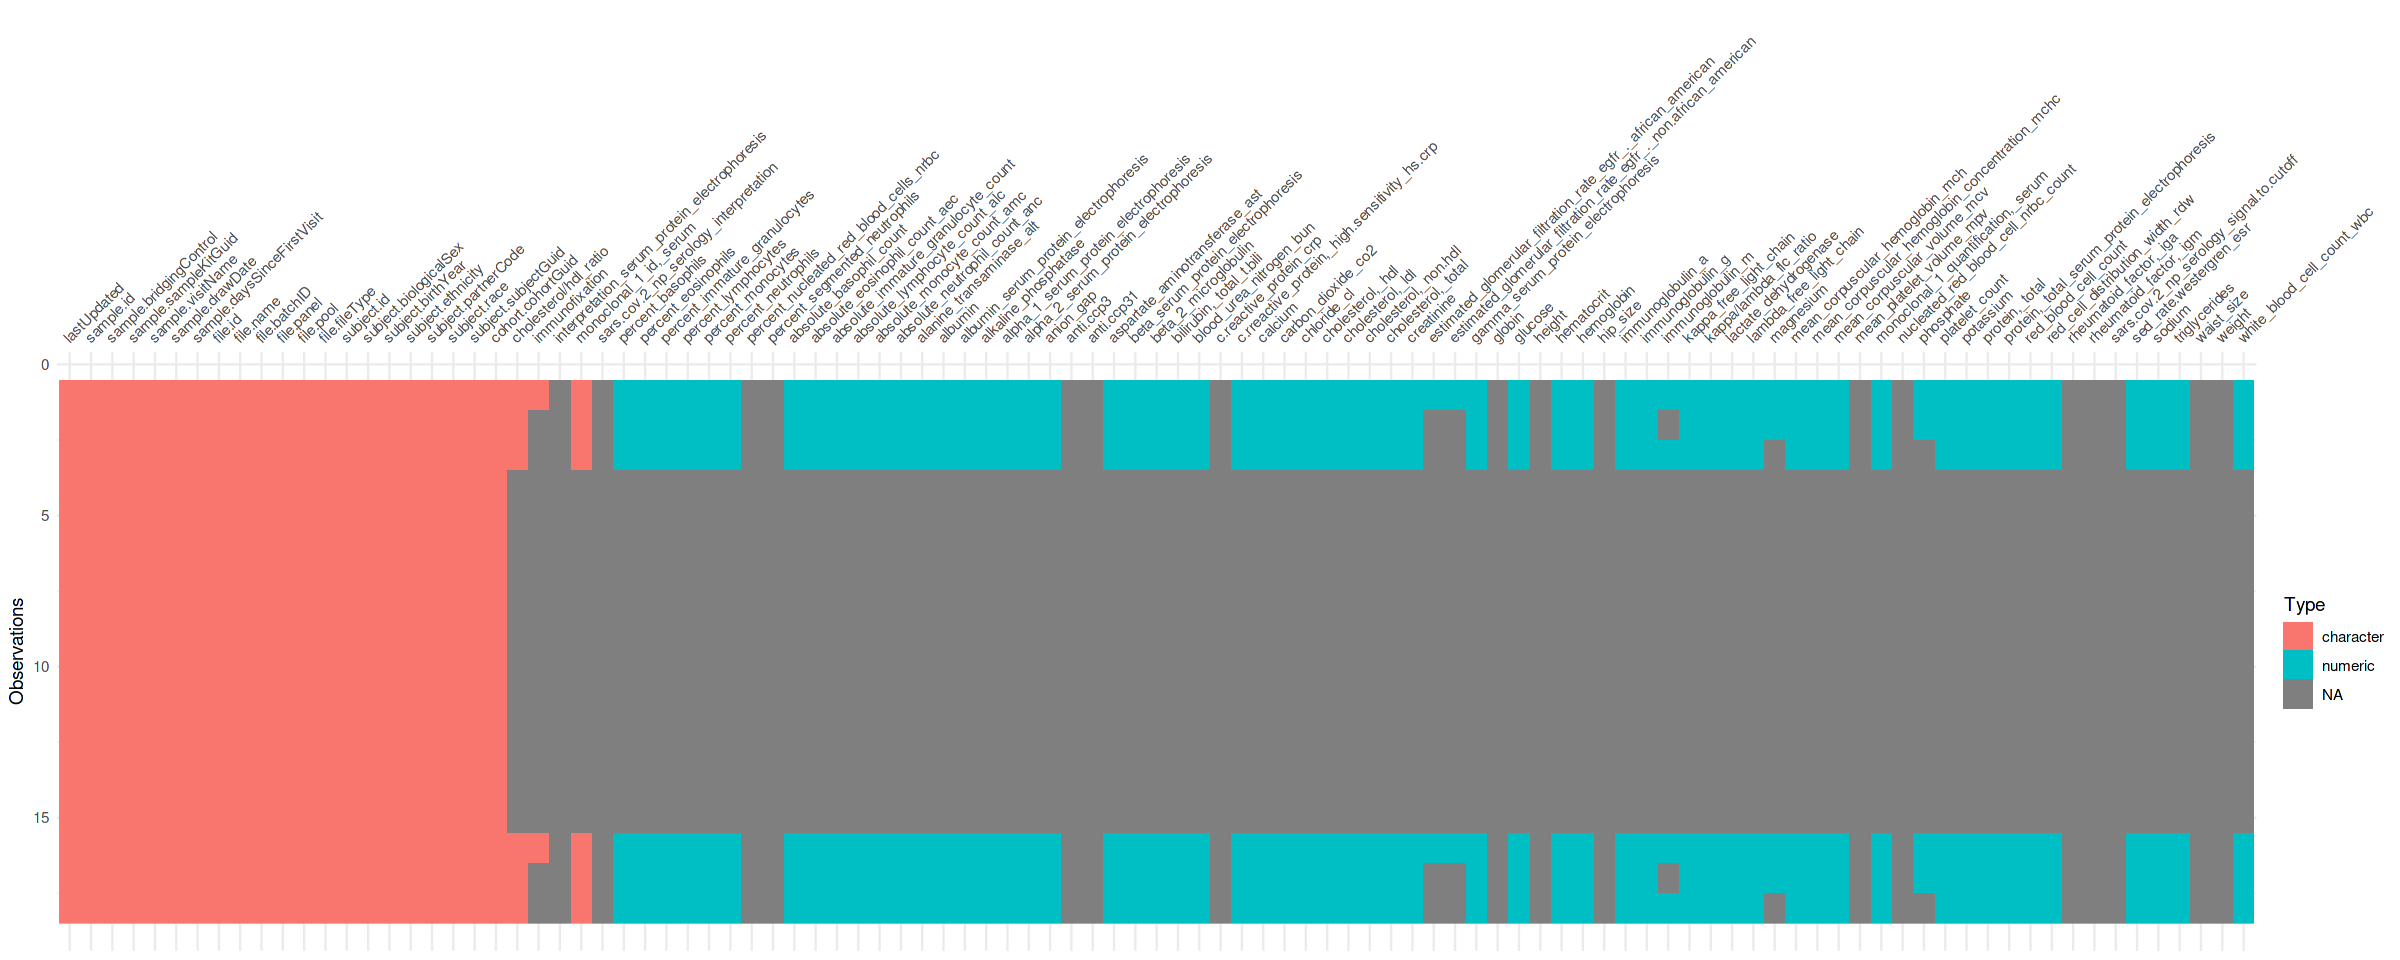

In [9]:
options(repr.plot.width = 20, repr.plot.height = 8)
vis_dat(lab_results[lab_results$cohort.cohortGuid == "FH1",])

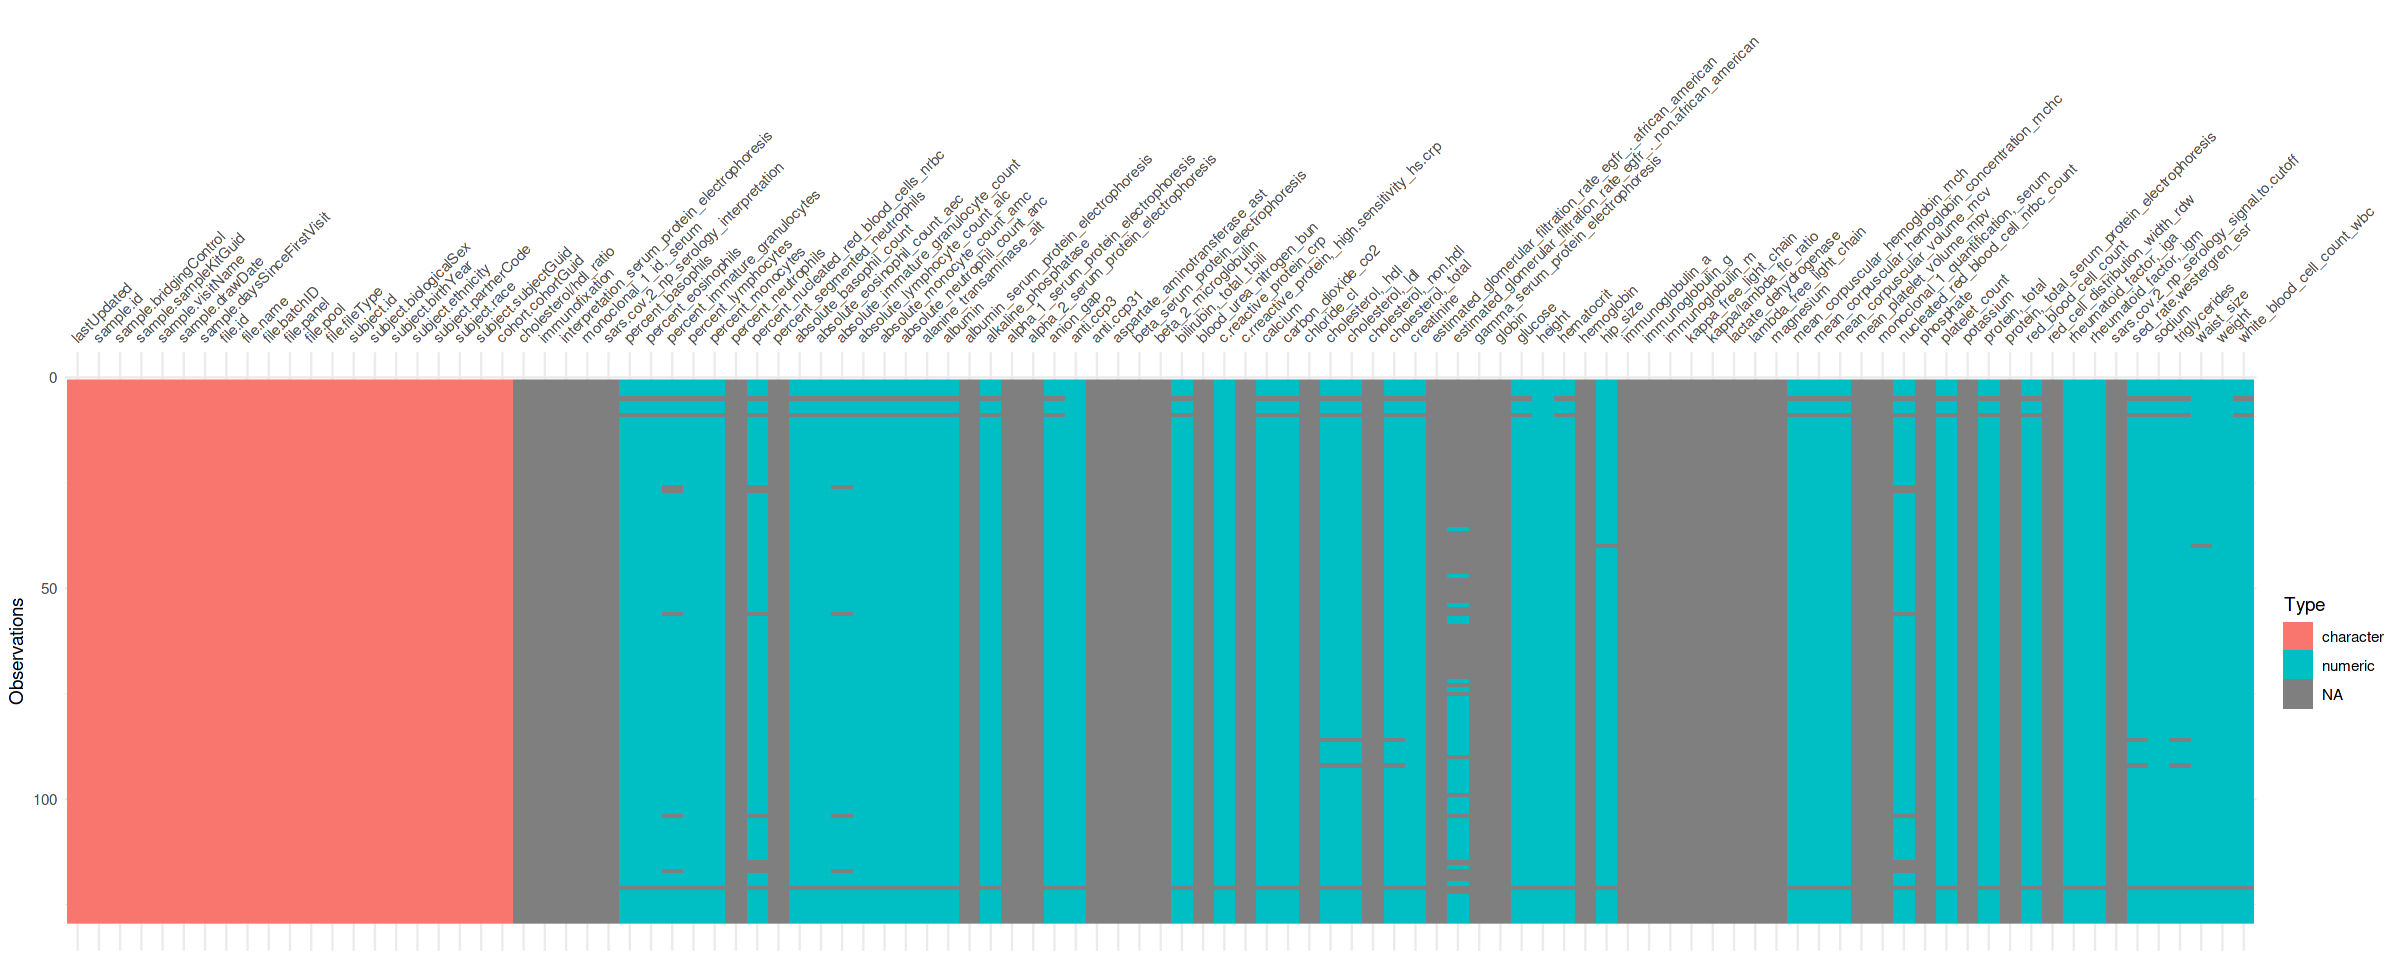

In [10]:
options(repr.plot.width = 20, repr.plot.height = 8)
vis_dat(lab_results[lab_results$cohort.cohortGuid %in% c("CU1","SD1"),])

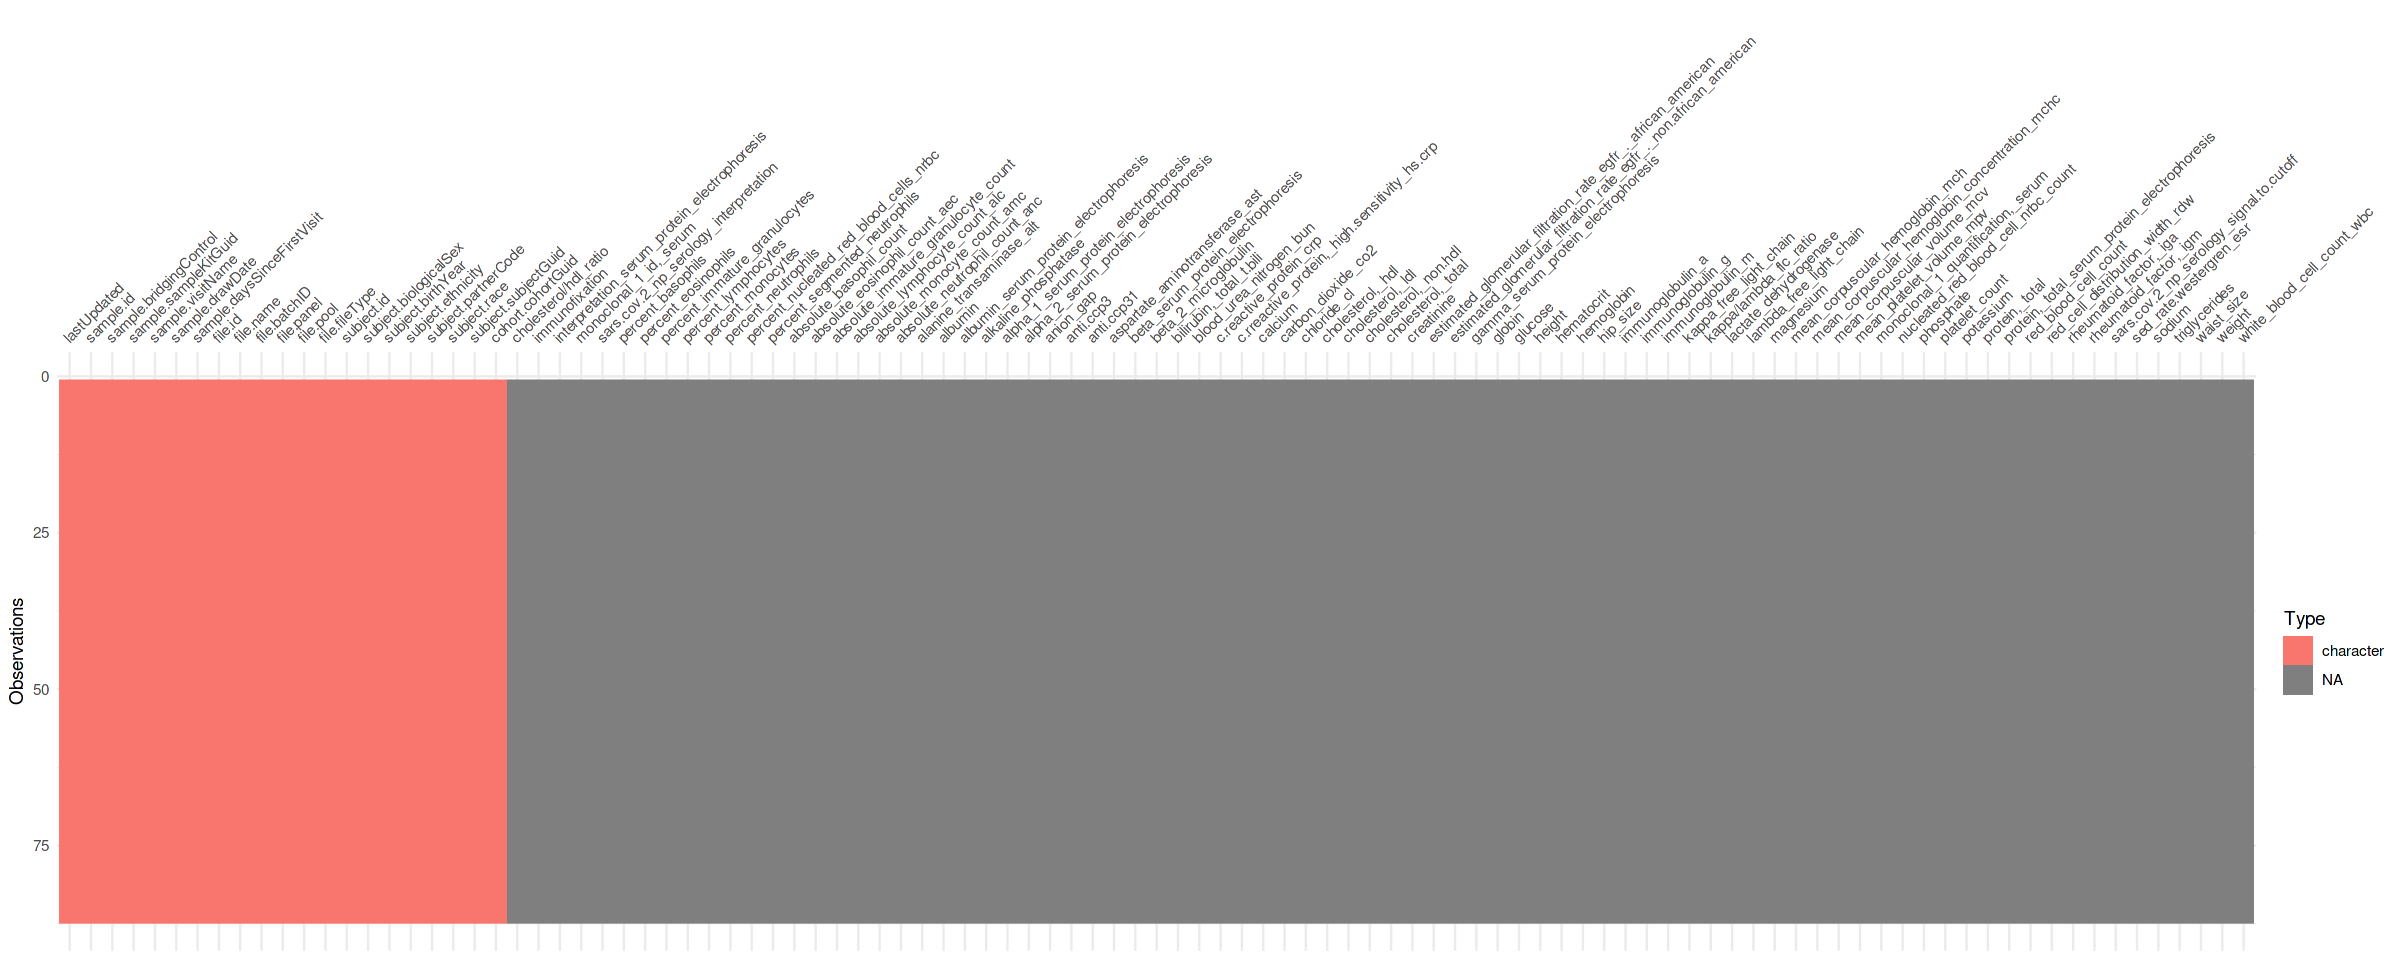

In [11]:
options(repr.plot.width = 20, repr.plot.height = 8)
vis_dat(lab_results[lab_results$cohort.cohortGuid %in% c("BR1","BR2"),])

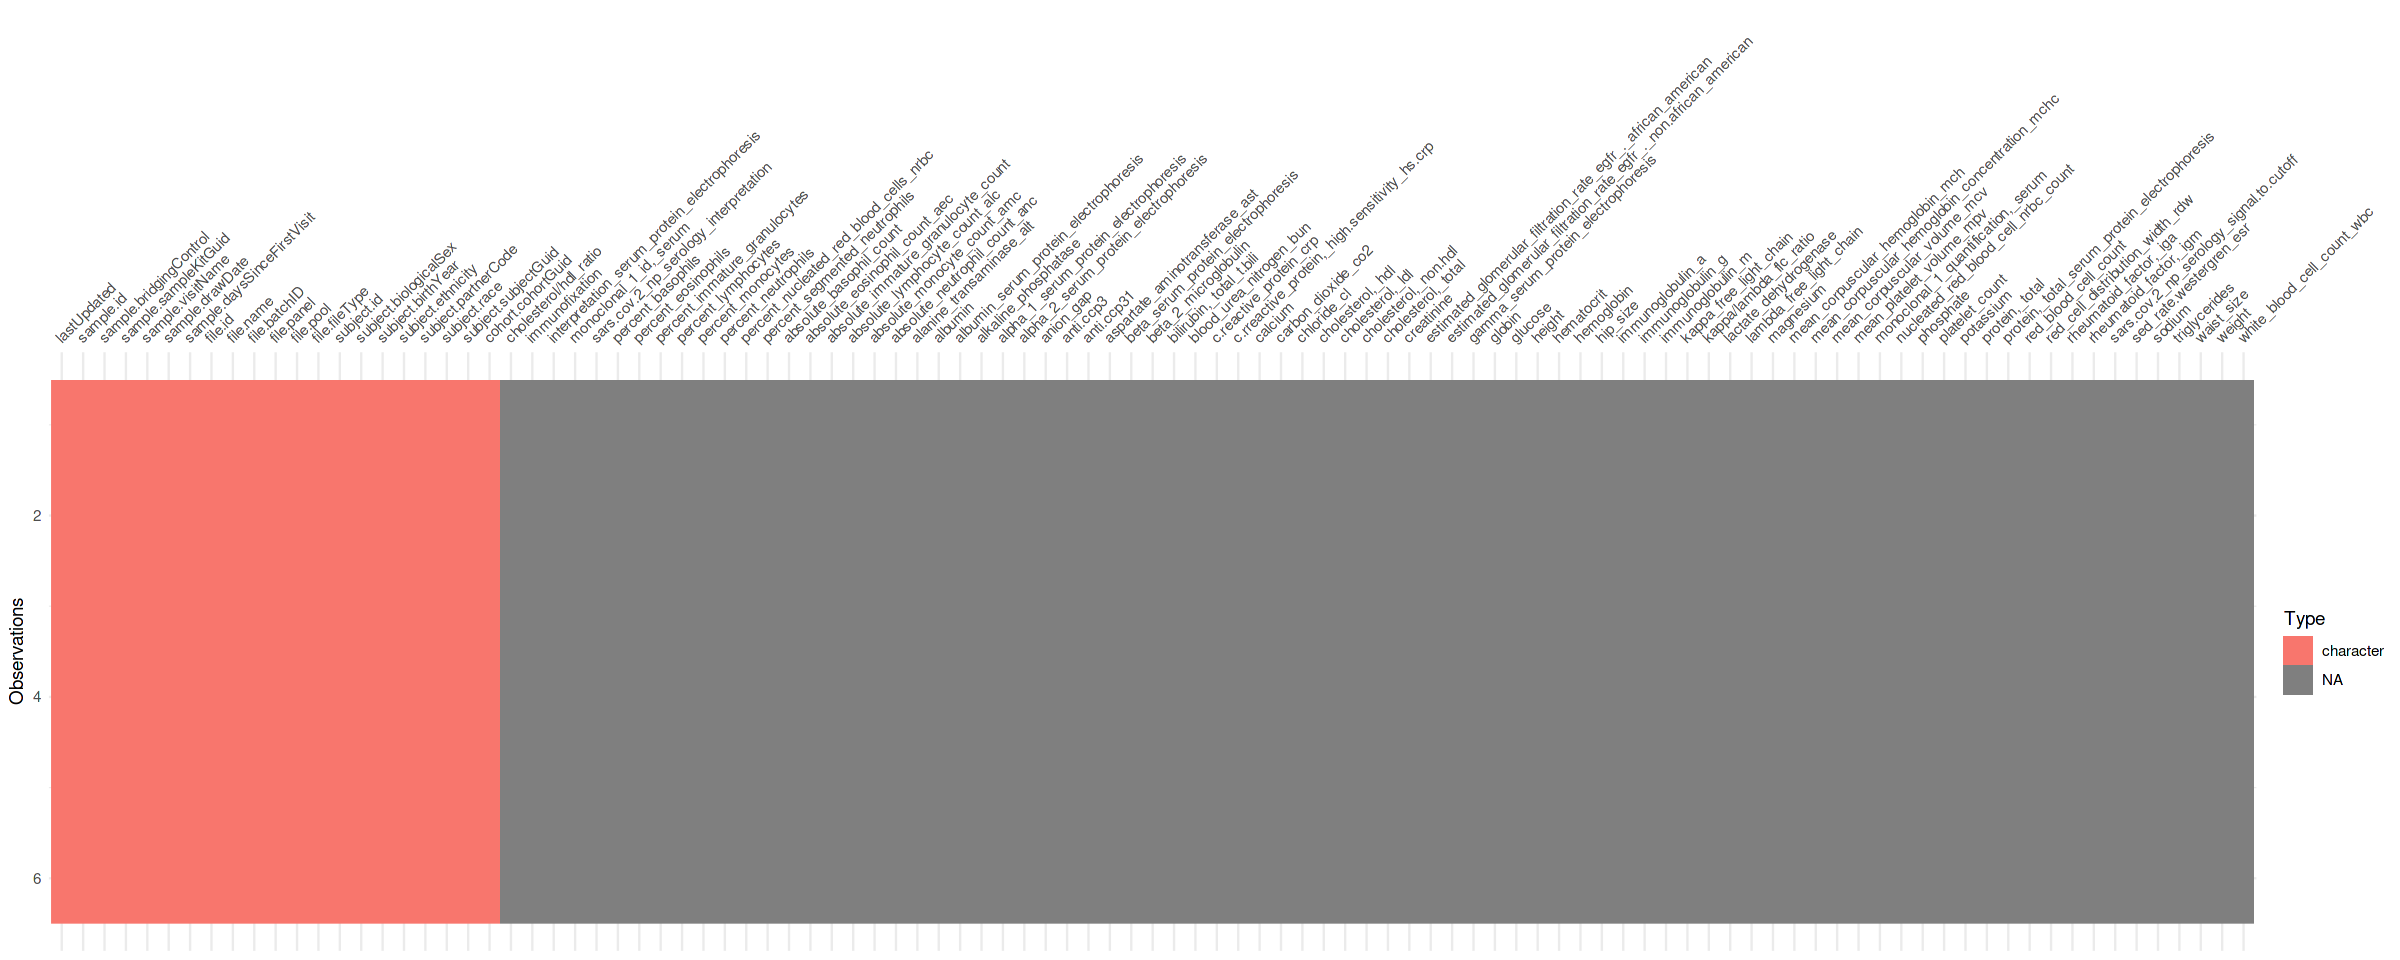

In [12]:
options(repr.plot.width = 20, repr.plot.height = 8)
vis_dat(lab_results[lab_results$cohort.cohortGuid == "UP1",])

### Session info

In [13]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] visdat_0.5.3 purrr_0.3.4  hise_1.0.3  

loaded via a namespace (and not attached):
 [1] pillar_1.6.0      compiler_4.0.5    base64enc_0.1-3   bitops_1.0-6     
 [5] tools_4.0.5       digest_0.6.27     uuid_0.1-4        gtable_0.3.0     
 [9] jsonlite_1.7.2    evaluate_0.14     lifecycle_1.0.0   tibble_3.1.1